In [288]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Load and Clean Data

In [77]:
building_raw = pd.read_csv('building_fire_risk.csv')
demo_raw = pd.read_csv('demographic_data/nyc_demographic_data.csv')
eco_raw = pd.read_csv('nyc_economic_data.csv')
fire_inc_all_raw = pd.read_csv('FireIncidenceAll.csv')
fire_inc_high_raw = pd.read_csv('HighRiskData.csv')
fire_inc_low_raw = pd.read_csv('LowRiskData.csv')

#### Demographic data (demo)

In [206]:
# Remove 'Total_Language_Population' column because all values are NaN and
# 'Median_Year_Built' because data is already captured in building data
demo = demo_raw.drop(['Total_Language_Population', 'Median_Year_Built'], axis=1)
demo.sample(5)

,ZIP,Total_Population,Median_Age,Male_Population,Female_Population,White,Black,American_Indian_Alaska_Native,Asian,Native_Hawaiian_Pacific_Islander,...,Not_in_Labor_Force,Employed,Unemployed,Median_Travel_Time,Total_With_Disability,No_Health_Insurance,Vehicles_Available,Foreign_Born,Median_Earnings,Households_with_Broadband
87,11204,75840,34.6,37784,38056,42054,808,465,25148,11,...,33634,33623,2187,28294,75784,0,23520,34293,31221,19075
46,10306,54318,42.2,26106,28212,43058,1874,125,4696,0,...,26447,26447,1593,23303,53864,9,19704,13304,54458,16718
66,10464,4322,43.4,2098,2224,3031,21,0,79,0,...,2538,2538,263,2113,4322,0,1874,935,62238,1614
20,10024,60714,41.2,26161,34553,50515,1773,164,4107,0,...,36324,36324,906,28373,60174,0,28850,11446,94064,26938
23,10027,64728,31.1,30474,34254,19471,25429,393,5512,6,...,31931,31927,2189,25142,64580,0,23835,16000,49558,19519


#### Building data (building)

In [75]:
# Assign risks to each zipcode
# high risk: 5, medium risk: 3, low risk: 1
building = building_raw.copy()
building = building.replace({'high':5, 'medium':3, 'low':1})

# Calculate total risk per zipcode
building['total_risk'] = building['risk'] * building['count']
build_risks = building.groupby('zipcode').sum()['total_risk']
building = building.merge(build_risks, on='zipcode', how='left').drop(['risk', 'count', 'total_risk_x'], axis=1).rename({'total_risk_y':'total_risk'}, axis=1)
building.drop_duplicates(inplace=True)

# Assign area_mile2 to zipcodes without value. Use minimum area_mile2 / 2
new_area_mile2 = building_raw.area_mile2.min() / 2
building.area_mile2 = building.area_mile2.fillna(new_area_mile2)

# Calculate average risk per zipcode
building['avg_build_risk'] = building.apply(lambda x: round(x['total_risk'] / x['area_mile2'], 3), axis=1)

# Keep useful columns and rename zipcode to ZIP to be consistent with other datasets
building = building[['zipcode', 'avg_build_risk']].rename({'zipcode': 'ZIP'}, axis=1)

building.sample(5)

C:\Users\kevin\AppData\Local\Temp\ipykernel_19508\3173270604.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  building = building.replace({'high':5, 'medium':3, 'low':1})


,ZIP,avg_build_risk
517,11414,9852.820
415,11237,20588.057
373,11222,16834.946
273,10475,2833.415
484,11372,23512.644


#### Economic data (eco)

In [165]:
eco = eco_raw.copy()
# Extract useful columns
eco = eco[['ZIP', 'est_households_total', 'est_households_median_income_dollars', 'est_households_mean_income_dollars', 
          'est_families_total', 'est_families_median_income_dollars', 'est_families_mean_income_dollars', 
          'est_married_couple_families_total', 'est_married_couple_families_median_income_dollars', 'est_married_couple_families_mean_income_dollars',
          'est_nonfamily_households_total', 'est_nonfamily_households_median_income_dollars', 'est_nonfamily_households_mean_income_dollars']]
eco.sample(5)

,ZIP,est_households_total,est_households_median_income_dollars,est_households_mean_income_dollars,est_families_total,est_families_median_income_dollars,est_families_mean_income_dollars,est_married_couple_families_total,est_married_couple_families_median_income_dollars,est_married_couple_families_mean_income_dollars,est_nonfamily_households_total,est_nonfamily_households_median_income_dollars,est_nonfamily_households_mean_income_dollars
87,11204,25306,67588.0,88033,19880,71338.0,93259,14653,75056.0,98942.0,5426,37090,52490
128,11360,8822,100250.0,130675,5099,147560.0,152344,4258,161144.0,NaN,3723,66673,98059
156,11694,8046,103792.0,131803,4929,128512.0,156862,3592,159135.0,NaN,3117,63546,88194
24,10028,24901,168125.0,282107,10580,NaN,464064,9481,NaN,NaN,14321,106564,147398
52,10314,31419,104655.0,131486,23446,123776.0,147844,17804,141035.0,NaN,7973,49408,71120


#### Fire Incident Data

In [157]:
# Extract useful columns
fire_inc_all = fire_inc_all_raw[['MODZCTA', 'Count']].rename({'MODZCTA':'ZIP', 'Count':'all_incident'}, axis=1)
fire_inc_low = fire_inc_low_raw[['MODZCTA', 'Count']].rename({'MODZCTA':'ZIP', 'Count':'low_incident'}, axis=1)
fire_inc_high = fire_inc_high_raw[['MODZCTA', 'Count']].rename({'MODZCTA':'ZIP', 'Count':'high_incident'}, axis=1)

In [158]:
# Combine all data and calculate medium risk incidents
inc = fire_inc_all.merge(fire_inc_low, on='ZIP', how='left')
inc = inc.merge(fire_inc_high, on='ZIP', how='left')
inc['med_incident'] = inc['all_incident'] - inc['high_incident'] - inc['low_incident']
inc.drop('all_incident', inplace=True, axis=1)

In [159]:
# Assign risks to each zipcode
risk_factor = {'high':5, 'medium':3, 'low':1}
inc['fire_incident_risk'] = inc['high_incident'] * risk_factor['high'] \
                            + inc['med_incident'] * risk_factor['medium'] \
                            + inc['low_incident'] * risk_factor['low']
# Drop 'low_incident', 'med_incident', 'high_incident' columns
inc = inc[['ZIP', 'fire_incident_risk']]

In [160]:
# Merge with buildings_raw to include area size
inc = inc.merge(building_raw, left_on='ZIP', right_on='zipcode', how='left').drop_duplicates('ZIP')[['ZIP', 'fire_incident_risk', 'area_mile2']]

In [161]:
# Calculate average fire_incident risk per sq mile
inc['avg_fire_incident_risk'] = inc.apply(lambda x: round(x['fire_incident_risk'] / x['area_mile2'], 3), axis=1)
inc = inc[['ZIP', 'avg_fire_incident_risk']]
inc

,ZIP,avg_fire_incident_risk
0,10001,28641.249
3,10002,40421.131
6,10003,31500.887
9,10004,5371.265
12,10005,34034.196
...,...,...
516,11691,7304.911
519,11692,5117.900
522,11693,3943.588
525,11694,3576.947


# Combine Data

In [231]:
# demo + building = df
df = demo.merge(building, on='ZIP')

# df + eco = df
df = df.merge(eco, on='ZIP')

# df + inc = df
df = df.merge(inc, on='ZIP')

df.sample(5)

,ZIP,Total_Population,Median_Age,Male_Population,Female_Population,White,Black,American_Indian_Alaska_Native,Asian,Native_Hawaiian_Pacific_Islander,...,est_families_total,est_families_median_income_dollars,est_families_mean_income_dollars,est_married_couple_families_total,est_married_couple_families_median_income_dollars,est_married_couple_families_mean_income_dollars,est_nonfamily_households_total,est_nonfamily_households_median_income_dollars,est_nonfamily_households_mean_income_dollars,avg_fire_incident_risk
67,10465,45066,39.6,22015,23051,25152,5947,10,1932,8,...,11065,109012.0,123531,6638,141229.0,NaN,5156,38817,71048,3514.666
117,11235,76921,45.4,36816,40105,56486,1687,54,10094,0,...,21869,82520.0,120263,16116,92630.0,134080.0,13464,34788,53259,7457.539
98,11215,69995,36.6,34026,35969,51922,2848,159,6389,0,...,17560,223697.0,300538,14865,247813.0,NaN,12187,117979,146946,7775.742
135,11368,108661,33.7,56848,51813,34083,10529,998,14467,11,...,22321,70817.0,85725,12144,75100.0,NaN,7538,40123,56810,6234.789
85,11201,64798,35.0,30947,33851,41093,7977,208,8634,41,...,14432,244063.0,330599,11191,NaN,NaN,18709,132353,171534,18876.162


# Prep Data for Model

In [232]:
df.isna().sum()

ZIP                                                    0
Total_Population                                       0
Median_Age                                             0
Male_Population                                        0
Female_Population                                      0
White                                                  0
Black                                                  0
American_Indian_Alaska_Native                          0
Asian                                                  0
Native_Hawaiian_Pacific_Islander                       0
Other_Race                                             0
Two_or_More_Races                                      0
Median_Household_Income                                0
Poverty_Total                                          0
Below_Poverty                                          0
Total_Educ_25plus                                      0
Bachelor_Degree                                        0
Advanced_Degree                

In [233]:
# Remove 'est_married_couple_families_median_income_dollars' and 
# 'est_married_couple_families_mean_income_dollars' column because 141 and 22 rows are NA's
df.drop(['est_married_couple_families_median_income_dollars', 'est_married_couple_families_mean_income_dollars']
        , axis=1, inplace=True)

In [234]:
# est_households_median_income_dollars: 2 NA's
# Use avg ratio of est_households_median_income_dollars and est_households_mean_income_dollars to imputate missing values
ratio = np.mean(df.est_households_median_income_dollars / df.est_households_mean_income_dollars)
df.est_households_median_income_dollars = df.est_households_median_income_dollars.fillna(df.est_households_mean_income_dollars * ratio)
# est_families_median_income_dollars: 14 NA's
# Use avg ratio of est_families_median_income_dollars and est_families_mean_income_dollars to imputate missing values
ratio = np.mean(df.est_families_median_income_dollars / df.est_families_mean_income_dollars)
df.est_families_median_income_dollars = df.est_families_median_income_dollars.fillna(df.est_families_mean_income_dollars * ratio)


In [236]:
train_data = df.sample(frac=0.75, random_state=6242)
test_data = df.drop(train_data.index)
X_train = train_data.drop('avg_fire_incident_risk', axis=1)
y_train = train_data[['ZIP', 'avg_fire_incident_risk']]
X_test = test_data.drop('avg_fire_incident_risk', axis=1)
y_test = test_data[['ZIP', 'avg_fire_incident_risk']]

In [240]:
# Normalize data
normalizer = Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

# DNN Prediction Model

In [347]:
def build_and_compile_model(norm):
  model = Sequential([
      norm,
      Dense(64, activation='relu'),
      Dense(64, activation='relu'),
      Dense(64, activation='relu'),
      Dense(64, activation='relu'),
      Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=Adam(0.001))
  return model

In [348]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_5 (Normalization)      │ (None, 45)                  │              91 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91 (368.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 91 (368.00 B)

In [349]:
%%time
history = dnn_model.fit(X_train, y_train, validation_split=0.2, verbose=0, epochs=500)

CPU times: total: 4.72 s
Wall time: 22.8 s


In [350]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.grid(True)

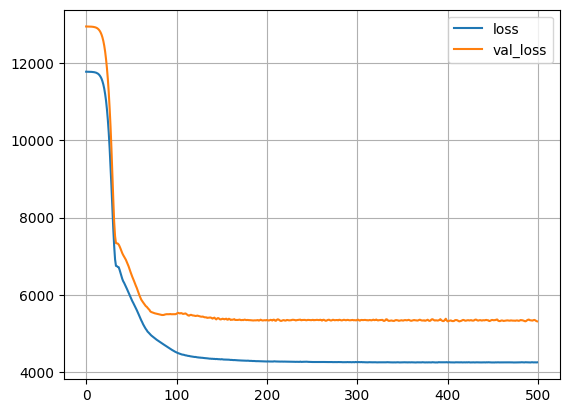

In [351]:
plot_loss(history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


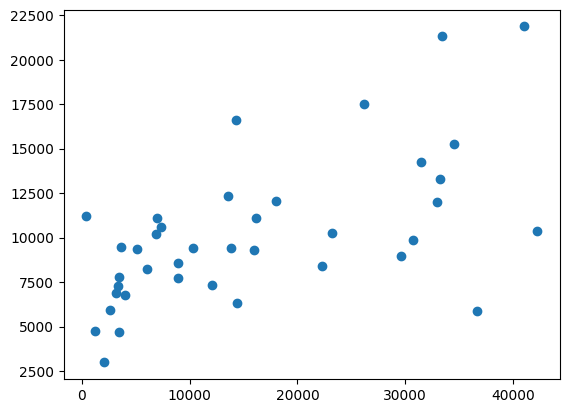

In [352]:
plt.scatter(y_test.avg_fire_incident_risk, dnn_model.predict(X_test).flatten());

In [353]:
r2_score(y_test.avg_fire_incident_risk, dnn_model.predict(X_test).flatten()), \
r2_score(y_train.avg_fire_incident_risk, dnn_model.predict(X_train).flatten())

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


(0.06721832555682905, 0.1952873608994895)